In [1]:
# General
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pytz
from pandas.api.types import CategoricalDtype
from global_land_mask import globe

# Models
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
import graphviz
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Geolocation libraries
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns

# Information

This notebook serves to Explore, Analyse and Model the global collection of wildlife mammalian species. 
The dataset comprises approximately 200 species from a global coverage. 

The research question targetted here, relates to the capacity of spatiotemporal metadata to accurately predict wildlife species independently from image classification. 

## Generate Final Dataset

In [8]:
file_path = '../../data/processed/'

#### Wildlife Observations from Inaturalist

In [9]:
wildlife_df = pd.read_csv(file_path + 'observations_final.csv', index_col=0)

In [10]:
wildlife_df.head()

,observed_on,local_time_observed_at,latitude,longitude,positional_accuracy,public_positional_accuracy,image_url,license,geoprivacy,taxon_geoprivacy,scientific_name,common_name,taxon_id
id,,,,,,,,,,,,,
128984633,2022-08-02,2022-08-02 00:40:00+10:00,-30.490071,151.639271,11,11,https://static.inaturalist.org/photos/21914219...,NaN,NaN,open,Phascolarctos cinereus,Koala,42983
129048796,2022-08-02,2022-08-02 07:55:55+10:00,-38.671312,146.164746,24,24,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY-NC,NaN,open,Wallabia bicolor,Swamp Wallaby,42973
129051266,2022-08-02,2022-08-02 00:20:13+02:00,43.119623,-7.678884,8,8,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY,NaN,open,Plecotus auritus,Brown Big-eared Bat,40416
129054418,2022-08-02,2022-08-02 00:26:13+02:00,50.686439,7.169781,6,6,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY-NC,NaN,NaN,Erinaceus europaeus,Common Hedgehog,43042
129076855,2022-08-02,2022-08-02 13:32:23+12:00,-40.949812,174.971092,5,5,https://inaturalist-open-data.s3.amazonaws.com...,NaN,NaN,open,Arctocephalus forsteri,New Zealand Fur Seal,41752


In [5]:
print("Shape: ", wildlife_df.shape)
print("Columns: ", wildlife_df.columns)

Shape:  (1648194, 13)
Columns:  Index(['observed_on', 'local_time_observed_at', 'latitude', 'longitude',
       'positional_accuracy', 'public_positional_accuracy', 'image_url',
       'license', 'geoprivacy', 'taxon_geoprivacy', 'scientific_name',
       'common_name', 'taxon_id'],
      dtype='object')


#### Open-Meteo Weather Data

In [6]:
weather_df = pd.read_csv(file_path + 'weather_final.csv', index_col=0)

In [7]:
weather_df.head()

,lat,long,observed_on,time_zone,elevation,time,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,...,rain_sum,snowfall_sum,precipitation_hours,sunrise,sunset,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration_daily
id,,,,,,,,,,,,,,,,,,,,,
128984633,-30.490071,151.639271,2022-08-02 00:40:00+10:00,Australia/Sydney,1000.0,2022-08-02T00:00,7.6,99.0,7.5,5.1,...,0.0,0.0,0.0,2022-08-02T07:37,2022-08-02T18:21,12.6,27.0,161.0,14.14,1.91
129048796,-38.671312,146.164746,2022-08-02 07:55:55+10:00,Australia/Melbourne,166.0,2022-08-02T07:00,9.7,76.0,5.7,4.3,...,0.0,0.0,0.0,2022-08-02T08:15,2022-08-02T18:28,33.4,57.2,132.0,9.59,1.98
129051266,43.119623,-7.678884,2022-08-02 00:20:13+02:00,Europe/Madrid,477.0,2022-08-02T00:00,18.1,91.0,16.6,19.3,...,0.0,0.0,0.0,2022-08-02T06:20,2022-08-02T20:53,13.5,32.0,51.0,25.69,5.14
129054418,50.686439,7.169781,2022-08-02 00:26:13+02:00,Europe/Berlin,65.0,2022-08-02T00:00,17.3,85.0,14.7,17.9,...,0.0,0.0,0.0,2022-08-02T04:57,2022-08-02T20:17,11.9,32.0,208.0,19.41,4.47
129076855,-40.949812,174.971092,2022-08-02 13:32:23+12:00,Pacific/Auckland,0.0,2022-08-02T13:00,13.3,72.0,8.4,6.9,...,0.6,0.0,5.0,2022-08-02T08:24,2022-08-02T18:27,43.9,86.0,131.0,6.93,2.16


In [8]:
print("Shape: ", weather_df.shape)
print("Columns: ", weather_df.columns)

Shape:  (1032896, 51)
Columns:  Index(['lat', 'long', 'observed_on', 'time_zone', 'elevation', 'time',
       'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
       'apparent_temperature', 'surface_pressure', 'precipitation', 'rain',
       'snowfall', 'cloudcover', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_high', 'shortwave_radiation', 'direct_radiation',
       'diffuse_radiation', 'windspeed_10m', 'windspeed_100m',
       'winddirection_10m', 'winddirection_100m', 'windgusts_10m',
       'et0_fao_evapotranspiration_hourly', 'weathercode_hourly',
       'vapor_pressure_deficit', 'soil_temperature_0_to_7cm',
       'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm',
       'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm',
       'soil_moisture_28_to_100cm', 'weathercode_daily', 'temperature_2m_max',
       'temperature_2m_min', 'apparent_temperature_max',
       'apparent_temperature_min', 'precipitation_sum', 'rain_sum',
       'snowfall_sum', 'preci

In [9]:
weather_df.describe()

,lat,long,elevation,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,surface_pressure,precipitation,rain,...,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration_daily
count,1.032896e+06,1.032896e+06,1.032896e+06,1.032896e+06,1.032896e+06,1.032896e+06,1.032896e+06,1.032896e+06,1.032896e+06,1.032896e+06,...,1.032896e+06,1.032896e+06,1.032896e+06,1.032896e+06,1.032896e+06,1.032896e+06,1.032896e+06,1.032896e+06,1.032896e+06,1.032896e+06
mean,3.213113e+01,-5.997144e+01,4.221572e+02,1.669687e+01,6.301130e+01,8.508267e+00,1.559140e+01,9.687119e+02,8.245293e-02,7.981655e-02,...,9.543139e+00,2.072955e+00,1.997211e+00,5.528619e-02,3.176621e+00,1.617393e+01,3.573203e+01,1.920370e+02,1.803031e+01,3.450179e+00
std,2.292348e+01,7.017431e+01,6.333550e+02,9.042960e+00,2.113256e+01,9.027928e+00,1.110996e+01,6.498137e+01,4.101311e-01,4.073324e-01,...,1.073154e+01,5.520156e+00,5.458274e+00,5.363496e-01,5.183642e+00,6.651193e+00,1.213990e+01,9.699175e+01,7.496042e+00,1.778855e+00
min,-7.784559e+01,-1.798028e+02,-4.270000e+02,-3.990000e+01,2.000000e+00,-4.330000e+01,-4.510000e+01,4.836000e+02,0.000000e+00,0.000000e+00,...,-4.840000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+00,7.900000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.113880e+01,-1.057657e+02,4.700000e+01,1.110000e+01,4.800000e+01,2.700000e+00,8.300000e+00,9.636000e+02,0.000000e+00,0.000000e+00,...,2.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.140000e+01,2.700000e+01,1.170000e+02,1.246000e+01,2.090000e+00
50%,3.900547e+01,-8.150886e+01,1.810000e+02,1.750000e+01,6.500000e+01,9.200000e+00,1.630000e+01,9.935000e+02,0.000000e+00,0.000000e+00,...,9.800000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,3.380000e+01,2.030000e+02,1.859000e+01,3.370000e+00
75%,4.452206e+01,-5.612703e+01,4.320000e+02,2.340000e+01,8.000000e+01,1.500000e+01,2.390000e+01,1.008100e+03,0.000000e+00,0.000000e+00,...,1.710000e+01,1.300000e+00,1.200000e+00,0.000000e+00,5.000000e+00,1.980000e+01,4.250000e+01,2.690000e+02,2.399000e+01,4.670000e+00
max,8.389204e+01,1.798129e+02,7.099000e+03,4.980000e+01,1.000000e+02,2.860000e+01,4.770000e+01,1.059500e+03,2.600000e+01,2.600000e+01,...,3.980000e+01,2.018000e+02,2.018000e+02,4.802000e+01,2.400000e+01,7.930000e+01,1.386000e+02,3.600000e+02,3.672000e+01,1.626000e+01


#### Combine Datasets

Remove all unneccessary columns from both datasets before merging

In [10]:
weather_df = weather_df.drop(columns=['lat', 'long', 'time'])

In [11]:
wildlife_df = wildlife_df.drop(columns=['observed_on', 'local_time_observed_at', 'positional_accuracy'])

Merge Datasets

In [12]:
df = pd.merge(wildlife_df, weather_df, how='inner', left_index=True, right_index=True)

In [13]:
assert df.shape[1] == 58

In [14]:
df.shape

(1032896, 58)

In [15]:
df.columns

Index(['latitude', 'longitude', 'public_positional_accuracy', 'image_url',
       'license', 'geoprivacy', 'taxon_geoprivacy', 'scientific_name',
       'common_name', 'taxon_id', 'observed_on', 'time_zone', 'elevation',
       'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
       'apparent_temperature', 'surface_pressure', 'precipitation', 'rain',
       'snowfall', 'cloudcover', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_high', 'shortwave_radiation', 'direct_radiation',
       'diffuse_radiation', 'windspeed_10m', 'windspeed_100m',
       'winddirection_10m', 'winddirection_100m', 'windgusts_10m',
       'et0_fao_evapotranspiration_hourly', 'weathercode_hourly',
       'vapor_pressure_deficit', 'soil_temperature_0_to_7cm',
       'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm',
       'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm',
       'soil_moisture_28_to_100cm', 'weathercode_daily', 'temperature_2m_max',
       'temperature_2m_min', 'appare

## Exploratory Data Analysis

### Remove non-essential Columns
License will be removed after visualization of quantity. 

In [16]:
df = df.drop(columns=['geoprivacy', 'taxon_geoprivacy', 'taxon_id'])

### Detect any NaN values and their Column

In [17]:
df.columns[df.isnull().any()].tolist()

['image_url', 'license', 'common_name']

#### Remove NaN images

In [18]:
df = df.dropna(subset=['image_url'])

In [19]:
assert len(df[df['image_url'].isnull()]) == 0

#### Replace NaN licenses with 'No license'

In [20]:
df['license'] = df['license'].fillna('no license')

In [21]:
assert len(df[df['image_url'].isnull()]) == 0

#### Remove all rows with no common name

In [22]:
df = df.dropna(subset=['common_name'])

In [23]:
assert len(df[df['common_name'].isnull()]) == 0

## License Counts
Determine the image licenses and the quantity for each license type.

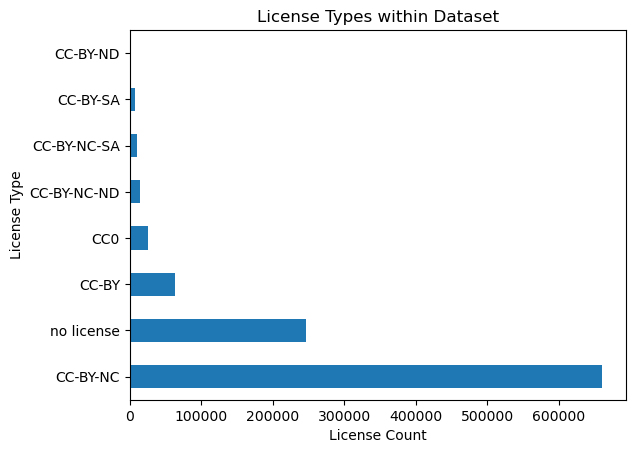

In [24]:
license_count = df['license'].value_counts(sort=True)
license_count.plot.barh()

plt.title('License Types within Dataset')
plt.ylabel('License Type')
plt.xlabel('License Count')
plt.show()

#### License Descriptions
In the EU, Article 3 of the Directive on Copyright in the Digital Single Market (DSM) provides an exception for non-commercial text-and-data mining by research and cultural institutions. (https://creativecommons.org/2021/03/04/should-cc-licensed-content-be-used-to-train-ai-it-depends/)

###### CC-BY-NC
Creative Commons Attribution NonCommercial (CC BY-NC) 4.0
You are free to: 
- Share - Copy and redistribute the material in any medium or format
- Adapt - Remix, transform, and build upon the material

Under the following terms: 
- Attribution - Give appropriate credit, provide a link to the license, and indicate if changes were made.
- Non-commerical - You may not use the material for commercial purposes. 
- No additional restrictions - You may not apply legal terms or technilogical measures that legally restrict others from doing anything the license permits. 
[more information here]
(https://creativecommons.org/licenses/by-nc/4.0/)

###### CC-BY
Creative Commons Attribution 4.0
You are free to: 
- Share - Copy and redistribute the material in any medium or format
- Adapt - Remix, transform, and build upon the material
Under the following terms: 
- You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in a reasonable manner, but not in any way that suggests the licensor endorses you or your use. 
[more information here](https://creativecommons.org/licenses/by/4.0/)

###### CC0
Universal Public Domain Dedication
The person who associated a work with this deed has **dedicated** the work to the public domain by waiving all of his or her rights to the work worldwide under copyright law, including all related and neighboring rights, to the extent allowed by law.

You can copy, modify, distribute and perform the work, even for commercial purposes, all without asking permission

Note: When using or citing the work, you should not imply endorsement by the author or the affirmer.
[more information here](https://creativecommons.org/publicdomain/zero/1.0/)

###### CC-BY-NC-ND
Attribution-NonCommercial-NoDerivatives 4.0 International
- ND: No derivatives or adaptions of the work are permitted

You are free to:
- Share — copy and redistribute the material in any medium or format

Under the following terms: 
- Attribution
- None-commerical
- No derivatives
[more information here](https://creativecommons.org/licenses/by-nc-nd/4.0/)

##### CC-BY-NC-SA
Attribution-NonCommercial-ShareAlike: CC BY-NC-SA
You are free to: 
- Share - Copy and redistribute the material in any medium or format
- Adapt - Remix, transform, and build upon the material

Under the following terms:
- Attribution
- None-commerical
- Share-Alike
[more information here](https://creativecommons.org/licenses/by-nc-sa/4.0/)

The above describes the most dominant license. The described licenses do not influence the use of the images due to the Research focus of the project. However attribution and accreditation will still be provided, especially to the platform iNaturalist.

Remove license column from dataset

In [25]:
df = df.drop(columns=['license'])

### Positional Accuracy

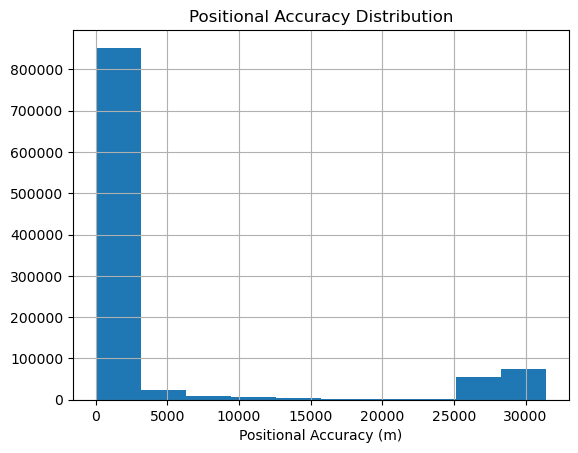

In [26]:
df['public_positional_accuracy'].hist()

plt.title('Positional Accuracy Distribution')
plt.xlabel('Positional Accuracy (m)')
plt.show()

The observation geograpic location falls into two catagories, those which are non-obscured (left hump) and thus a high accuracy, however for endangered species the accurate locations are obscured to within a random point within a 10km^2 bounding box, hence the peak near 30000. These values are accepted, such that weather conditions generally will spant the surrounding 10km radius, making them still representative of the weather conditions

In [27]:
df = df[df['public_positional_accuracy'] <= 35000]

In [28]:
df = df.drop(columns=['public_positional_accuracy'])

### Species Distributions

In [29]:
df['scientific_name'].describe()

count                  1028366
unique                    3641
top       Sciurus carolinensis
freq                     88274
Name: scientific_name, dtype: object

In [47]:
species_counts = df['common_name'].value_counts()
print(species_counts.head())

Eastern Grey Squirrel    88274
White-tailed Deer        78911
Eastern Cottontail       39737
Fox Squirrel             36168
Common Raccoon           34789
Name: common_name, dtype: int64


In [31]:
species_counts = species_counts[species_counts > 500]
print(len(species_counts))

212


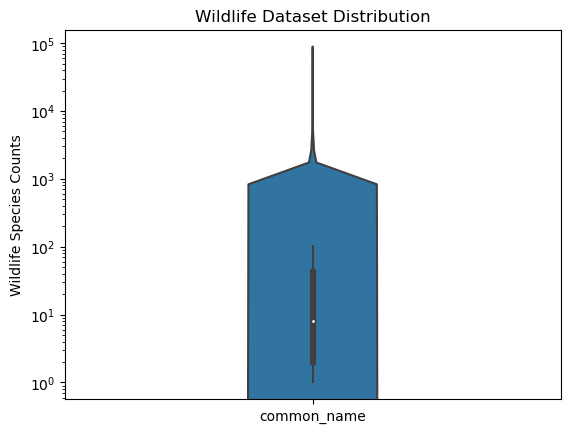

In [54]:
counts = species_counts.to_frame()
g1 = sns.violinplot(data=counts)
g1.set(xlabel=None)
plt.yscale('log')

plt.title('Wildlife Dataset Distribution')
plt.ylabel('Wildlife Species Counts')
plt.show()

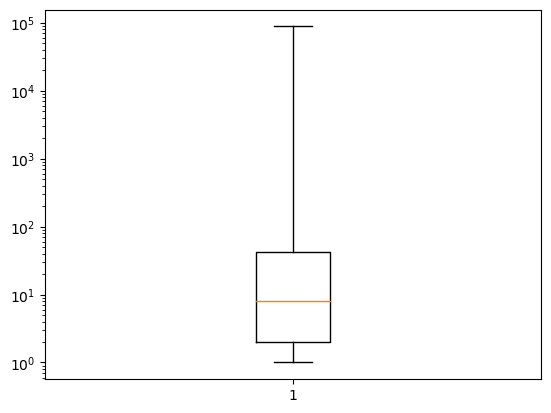

In [45]:
counts = species_counts.to_frame()
plt.boxplot(counts, whis=3000)
plt.yscale('log')
plt.show()

There exist approximately 200 species with ober 500 observations each. 
Remove all other species below 500 observations

In [32]:
df = df[df.groupby('common_name').common_name.transform('count')>500].copy() 

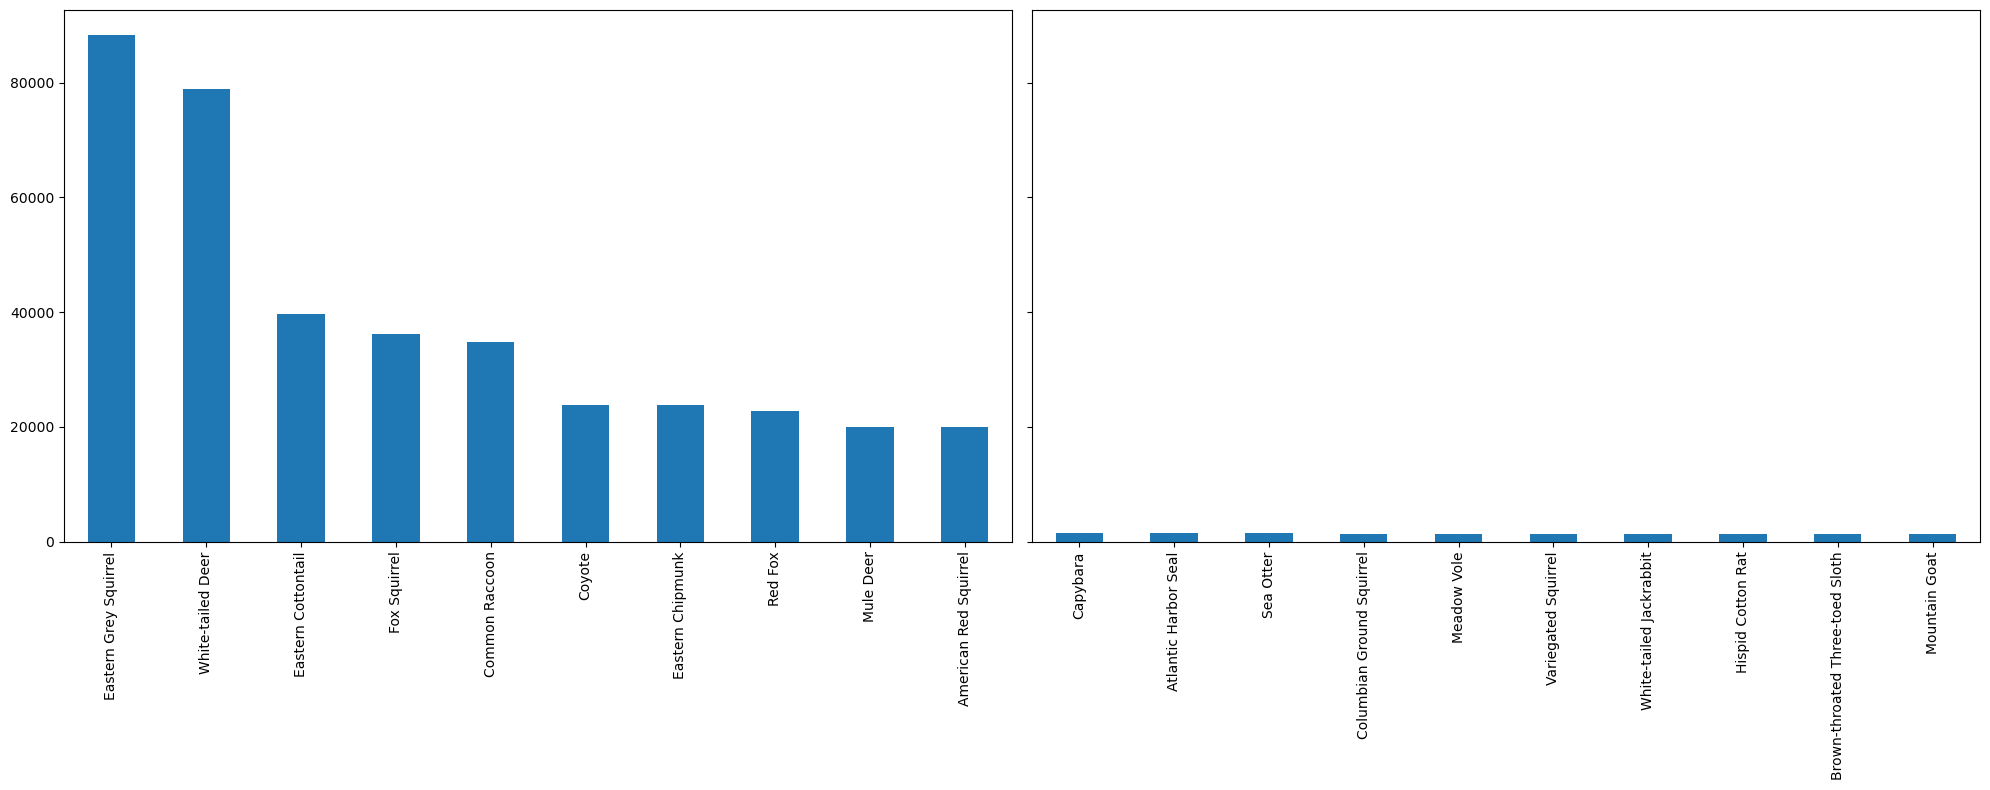

In [63]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8), sharey=True)
species_counts[0:10].plot(kind='bar', ax=ax1)
species_counts[90:100].plot(kind='bar', ax=ax2)
fig.tight_layout()
plt.show()

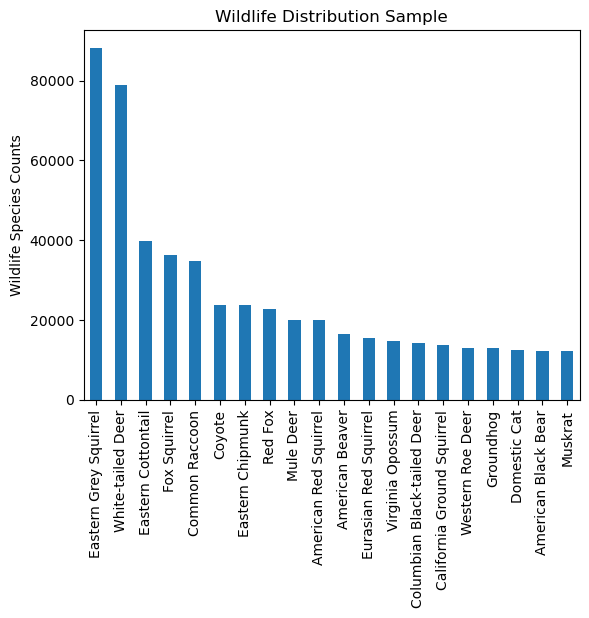

In [59]:
# Visualizations
species_counts[0:20].plot(kind='bar')
plt.title('Wildlife Distribution Sample')
plt.ylabel('Wildlife Species Counts')
plt.show()

# species_counts[50:100].plot(kind='bar')
# plt.show()

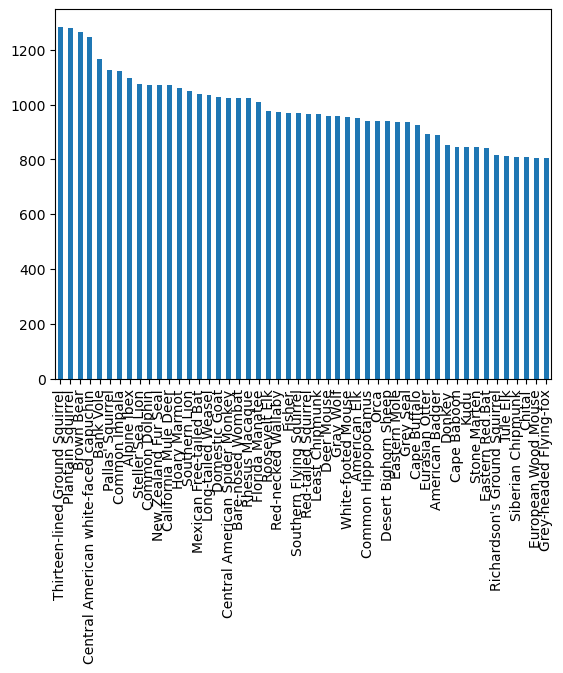

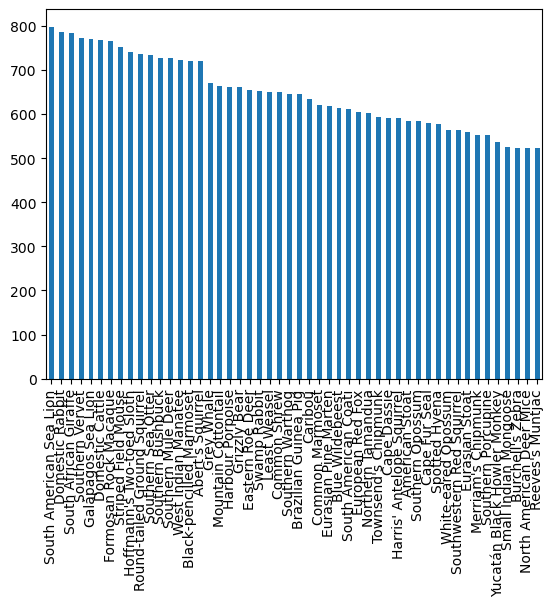

In [34]:
species_counts[100:150].plot(kind='bar')
plt.show()

species_counts[150:200].plot(kind='bar')
plt.show()

## Observation Geographical Distribution

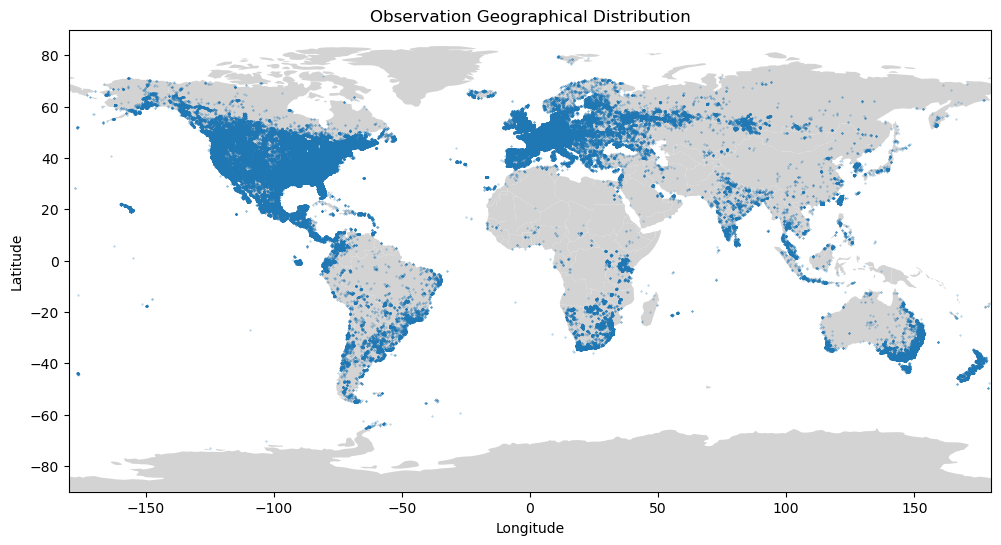

In [35]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

x = df['longitude']
y = df['latitude']

plt.scatter(x, y, s=0.1, alpha=0.6)

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.title("Observation Geographical Distribution")

plt.show()

#### Terrestrial vs Aquatic Feature

In [36]:
def land_mask(x):
    latitude = x['latitude']
    longitude = x['longitude']
    x['land'] = int(globe.is_land(latitude, longitude))
    return x

In [37]:
df = df.apply(lambda x: land_mask(x), axis=1)

In [38]:
df.head()

,latitude,longitude,image_url,scientific_name,common_name,observed_on,time_zone,elevation,temperature_2m,relativehumidity_2m,...,snowfall_sum,precipitation_hours,sunrise,sunset,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration_daily,land
id,,,,,,,,,,,,,,,,,,,,,
128984633,-30.490071,151.639271,https://static.inaturalist.org/photos/21914219...,Phascolarctos cinereus,Koala,2022-08-02 00:40:00+10:00,Australia/Sydney,1000.0,7.6,99.0,...,0.0,0.0,2022-08-02T07:37,2022-08-02T18:21,12.6,27.0,161.0,14.14,1.91,1
129048796,-38.671312,146.164746,https://inaturalist-open-data.s3.amazonaws.com...,Wallabia bicolor,Swamp Wallaby,2022-08-02 07:55:55+10:00,Australia/Melbourne,166.0,9.7,76.0,...,0.0,0.0,2022-08-02T08:15,2022-08-02T18:28,33.4,57.2,132.0,9.59,1.98,1
129054418,50.686439,7.169781,https://inaturalist-open-data.s3.amazonaws.com...,Erinaceus europaeus,Common Hedgehog,2022-08-02 00:26:13+02:00,Europe/Berlin,65.0,17.3,85.0,...,0.0,0.0,2022-08-02T04:57,2022-08-02T20:17,11.9,32.0,208.0,19.41,4.47,1
129076855,-40.949812,174.971092,https://inaturalist-open-data.s3.amazonaws.com...,Arctocephalus forsteri,New Zealand Fur Seal,2022-08-02 13:32:23+12:00,Pacific/Auckland,0.0,13.3,72.0,...,0.0,5.0,2022-08-02T08:24,2022-08-02T18:27,43.9,86.0,131.0,6.93,2.16,0
129090780,-30.489953,151.641020,https://inaturalist-open-data.s3.amazonaws.com...,Phascolarctos cinereus,Koala,2022-08-02 00:38:24+10:00,Australia/Sydney,1005.0,7.5,99.0,...,0.0,0.0,2022-08-02T07:37,2022-08-02T18:21,12.6,27.0,161.0,14.14,1.90,1


In [39]:
aquatic_df = df[df['land'] == 0]

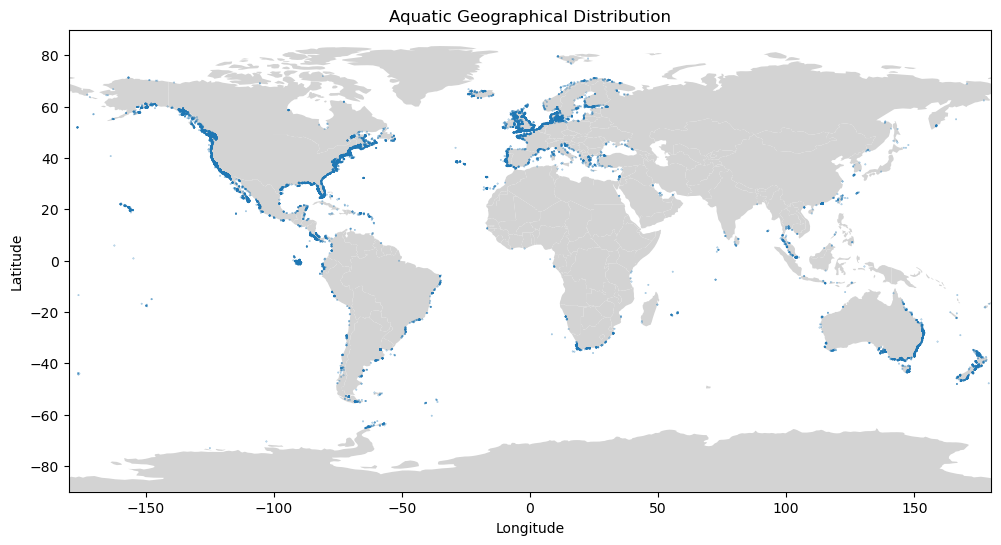

In [40]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

x = aquatic_df['longitude']
y = aquatic_df['latitude']

colours = {0: 'tab:blue', 1: 'tab:green'}
plt.scatter(x, y, s=0.1, alpha=0.6, c=aquatic_df['land'].map(colours))

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.title("Aquatic Geographical Distribution")

plt.show()

#### Coordinate Feature

In order to effectively use latitude and longitude within ML models, we will have to transform it into a more usable feature, as leaving it within its current form, would require the use of models that use non-normalized features. 

There exist two options for coordinate data [link here](https://medium.com/@khadijamahanga/using-latitude-and-longitude-data-in-my-machine-learning-problem-541e2651e08c#:~:text=You%20can%20use%20clustering%20algorithm,your%20latitude%20and%20longitude%20column.):
1. Choose a model not requiring you to normalize such features
2. Grid the world, forming square zones. This could be achieved by rouning the present coordinate values
3. Create zones with unique ID's using a clustering algorithm. 

The clustering method, should prove most useful in this situation, as there exist hotspots of observations throughout the world, corresponding to natural areas such as wildlife parks, etc. 
Experimentation will be required as to the granularity of such regions. 

In [69]:
location_data = df[['latitude', 'longitude']]
location_df_sample = location_data.sample(frac=0.05, random_state=1)

In [65]:
location_df_sample.shape

(51418, 2)

In [66]:
location_matrix = location_df_sample.to_numpy()
location_matrix

array([[  33.97818578,  -81.2263435 ],
       [ -38.61969909,  145.58617204],
       [  21.95662136, -159.5283572 ],
       ...,
       [ -28.7930774 ,  -57.48910431],
       [   4.6750708 ,  -74.16698429],
       [  40.44702833,  -79.92414167]])

Per k clusters a KMeans algorith is generated. Based on the centroids the Sum of Squared Errors is computed for each cluster. The aim is to identify clusters that represent observations hotspots accross the globe. 

In [44]:
# Possible alternative to use mini-batch k-means clustering algorithm for larger dataset

def calculate_optimal_k(data, k_max, interval, k_init):
    ssw = []
    
    k = k_init
    while k <= k_max:
        k_means = KMeans(n_clusters=k,  n_init=10).fit(data)
        centroids = k_means.cluster_centers_
        predicted_clusters = k_means.predict(data)
        sse = 0
        
        # Calculate distance from each point to cluster center. This is accumulated to be the SSW
        for locat in range(len(data)):
            centroid = centroids[predicted_clusters[locat]]
            sse += (data[locat, 0] - centroid[0]) ** 2 + (data[locat, 1] - centroid[1]) ** 2
            
        ssw.append(sse)
        
        k += interval
    return ssw

In [45]:
k_max = 1400
interval = 100
k_init = 200

kmeans_ssw = calculate_optimal_k(location_matrix, k_max, interval, k_init)

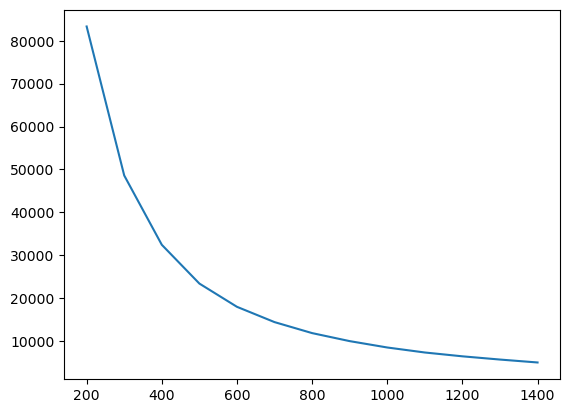

In [46]:
plt.plot(range(k_init, k_max + interval, interval), kmeans_ssw)
plt.show()

In [77]:
k_means = KMeans(n_clusters=200, n_init=10)
k_means.fit(location_matrix)
clusters = k_means.cluster_centers_

In [78]:
predicts = k_means.predict(location_df_sample)
counts = df = pd.DataFrame({'counts':predicts})
density = counts.value_counts()

/home/travisdawson/anaconda3/envs/spatiotemp_class_env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


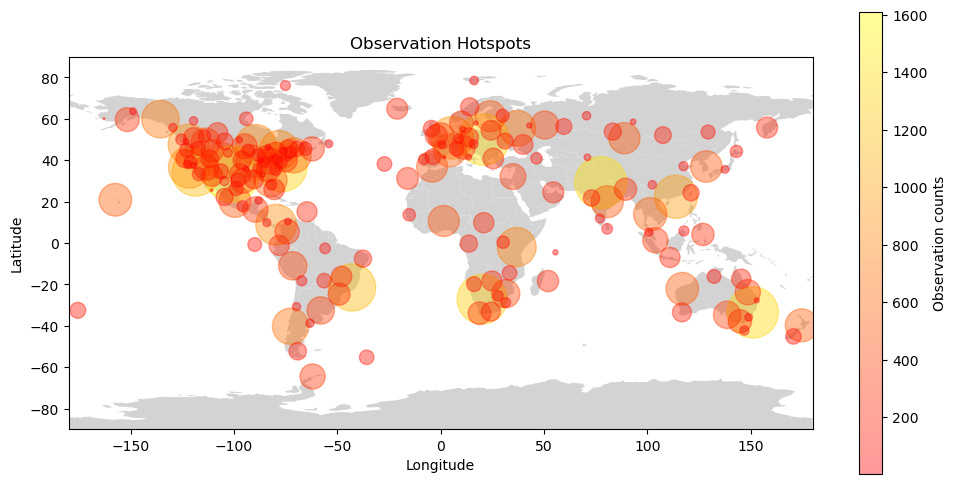

In [82]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

latitude = clusters[:, 0]
longitude = clusters[:, 1]

# plt.scatter(longitude, latitude, s=10, alpha=0.6)
plt.scatter(x=longitude, y=latitude, s=density , c=density, alpha=0.4, cmap='autumn')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.title("Observation Hotspots")
plt.colorbar(label='Observation counts')

plt.show()

Predict the label (index) of each cluster. This will form the unique location id for each observation.

In [49]:
df['location_cluster'] = k_means.predict(df[['latitude', 'longitude']])

/home/travisdawson/anaconda3/envs/spatiotemp_class_env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [50]:
df['location_cluster'].head()

id
128984633     41
129048796    188
129054418    125
129076855    112
129090780     41
Name: location_cluster, dtype: int32

#### North and South Hemisphere Feature
This feature can be used to inform the seasonality of each observation

In [51]:
df['hemisphere'] = (df['latitude'] >= 0).astype(int)

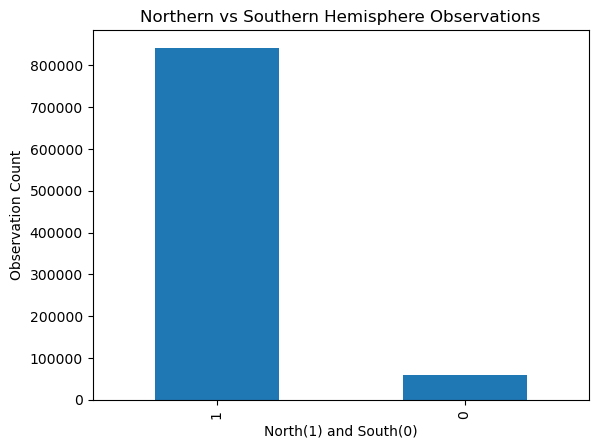

In [52]:
df['hemisphere'].value_counts().plot.bar()

plt.title('Northern vs Southern Hemisphere Observations')
plt.xlabel('North(1) and South(0)')
plt.ylabel('Observation Count')
plt.show()

Remove latitude and longitude and these features have been encapsulated better.

In [53]:
df = df.drop(columns=['latitude', 'longitude'])

### Date/ Time Features

Generate date_time object ob observation date time in UTC format. 
Features to extract include:
- Month of observation (UTC format acceptable)
- Hour of observation (local tim)
- Day/ Night OHE (Dark/ Light)
- Hemisphere encoding (North vs South)
- Season encoding (based on hemisphere)

### Month of observation

In [54]:
df['observed_on'].isnull().any()

False

In [55]:
df['observed_on'] = pd.to_datetime(df['observed_on'],
                                  format="%Y-%m-%d %H:%M:%S%z",
                                  utc=True)

In [56]:
df['month'] = df['observed_on'].dt.month

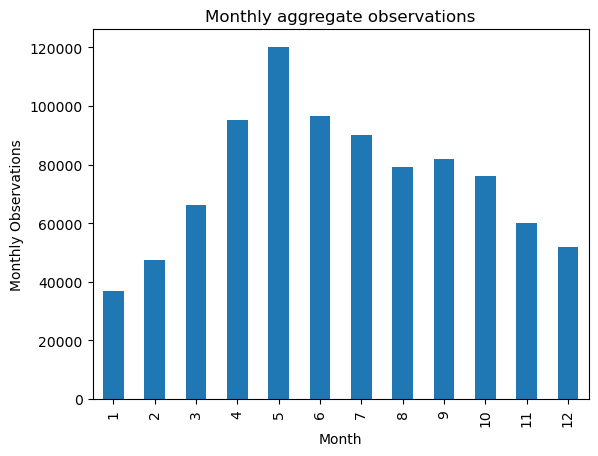

In [57]:
df['month'].value_counts().sort_index().plot.bar()

plt.title('Monthly aggregate observations')
plt.xlabel('Month')
plt.ylabel('Monthly Observations')
plt.show()

### Hour of observation

In [58]:
df['hour'] = df.apply(lambda x: x['observed_on'].astimezone(pytz.timezone(x['time_zone'])).hour, axis=1)

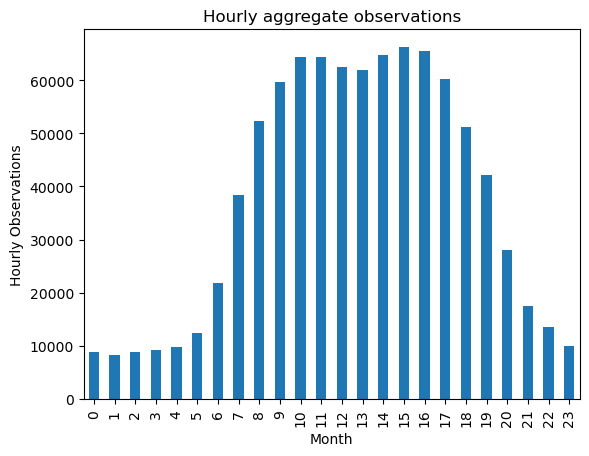

In [59]:
df['hour'].value_counts().sort_index().plot.bar()

plt.title('Hourly aggregate observations')
plt.xlabel('Month')
plt.ylabel('Hourly Observations')
plt.show()

Predominantly daily sightings, may bias model towards diurnal (active during the day) species.

### Dark/ Light 

In [60]:
df['sunrise'] = pd.to_datetime(df['sunrise'],
                                format="%Y-%m-%dT%H:%M",
                                errors='coerce')
df['sunset'] = pd.to_datetime(df['sunset'],
                                format="%Y-%m-%dT%H:%M",
                                errors='coerce')

df = df.dropna(subset=['sunrise', 'sunset'])

In [61]:
def localize_sunrise_sunset(x):
    timezone = pytz.timezone(x['time_zone'])
    x['sunrise'] = x['sunrise'].replace(tzinfo=timezone)
    x['sunset'] = x['sunset'].replace(tzinfo=timezone)
    return x

In [62]:
df = df.apply(lambda x: localize_sunrise_sunset(x), axis=1)

In [63]:
def dark_light_calc(x):
    timezone = pytz.timezone(x['time_zone'])
    sunrise_utc = x['sunrise']
    sunset_utc = x['sunset']
    
    observ_time = x['observed_on'].replace(tzinfo=pytz.utc)
    observ_time = x['observed_on'].astimezone(timezone)
    
    x['light'] = int(sunrise_utc <= observ_time <= sunset_utc)
    return x   

In [64]:
df = df.apply(lambda x: dark_light_calc(x), axis=1)

In [65]:
df['light'].head(10)

id
128984633    0
129048796    0
129054418    0
129076855    1
129090780    0
129090816    0
129094766    1
129096283    1
129098458    1
129099153    0
Name: light, dtype: int64

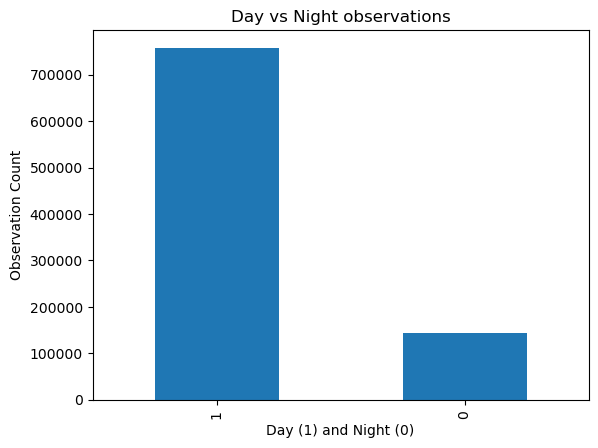

In [66]:
df['light'].value_counts().plot.bar()

plt.title('Day vs Night observations')
plt.xlabel('Day (1) and Night (0)')
plt.ylabel('Observation Count')
plt.show()

Create a method that encapsulates the day_night calculation to be used in the pipeline

In [67]:
def day_night_calculation(df):
    # Convert to datetime objects. Remove NaT values from resulting transformation
    df['sunrise'] = pd.to_datetime(df['sunrise'],
                                format="%Y-%m-%dT%H:%M",
                                errors='coerce')
    df['sunset'] = pd.to_datetime(df['sunset'],
                                format="%Y-%m-%dT%H:%M",
                                errors='coerce')
    df = df.dropna(subset=['sunrise', 'sunset'])
    
    # Localize sunrise and sunset times to be timezone aware
    df = df.apply(lambda x: localize_sunrise_sunset(x), axis=1)
    
    # Dark/ light calc based on sunrise and sunset times
    df = df.apply(lambda x: dark_light_calc(x), axis=1)
    
    return df

### Season

In [68]:
def season_calc(x):
    hemisphere = x['hemisphere']
    month = x['month']
    season = 0
    if hemisphere == 1: # Northern hemisphere
        winter, spring, summer, autumn = [12, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]
        seasons = [winter, spring, summer, autumn]
        season = north_south_calc(month, seasons)
    else:
        winter, spring, summer, autumn = [6, 7, 8], [9, 10, 11], [12, 1, 2], [3, 4, 5]
        seasons = [winter, spring, summer, autumn]
        season = north_south_calc(month, seasons)
    
    x['season'] = season
    return x
        
def north_south_calc(month: int, seasons: list):
    seasons_dict = {0: 'Winter', 1: 'Spring', 2: 'Summer', 3: 'Autumn'}
    season_id = 0
    for i in range(len(seasons)):
        if month in seasons[i]:
            season_id = i
    return seasons_dict[season_id]
    
        

In [69]:
df = df.apply(lambda x: season_calc(x), axis=1)

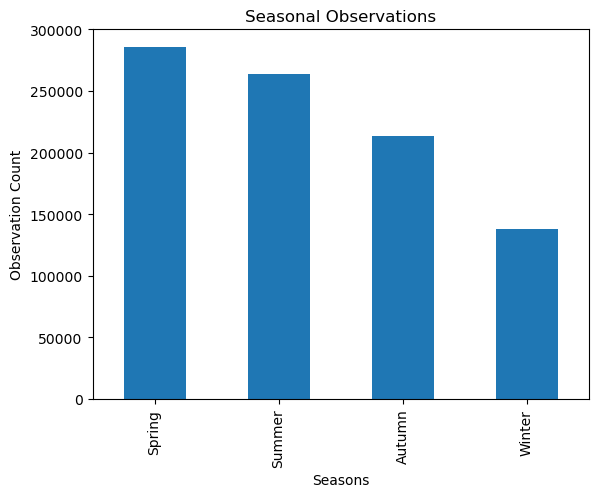

In [70]:
df['season'].value_counts().plot.bar()

plt.title('Seasonal Observations')
plt.xlabel('Seasons')
plt.ylabel('Observation Count')
plt.show()

In [71]:
def ohe_season(df):
    cats = ['Winter', 'Spring', 'Summer', 'Autumn']
    cat_type = CategoricalDtype(categories=cats)
    
    df['season'] = df['season'].astype(cat_type)
    
    df = pd.get_dummies(df,
                        prefix='szn',
                        columns=['season'], 
                        drop_first=True)
    return df

In [72]:
df = ohe_season(df)
df.filter(regex='szn').head(10)

,szn_Spring,szn_Summer,szn_Autumn
id,,,
128984633,0,0,0
129048796,0,0,0
129054418,0,1,0
129076855,0,0,0
129090780,0,0,0
129090816,0,0,0
129094766,0,0,0
129096283,0,0,0
129098458,0,0,0


### Weather Features

In [73]:
def elevation_clean(x):  # If observation is terrestrial, 0.0m elevation requires modification 
    land = x['land']
    elevation = x['elevation']
    if land == 1 and elevation == 0:
        x['elevation'] = np.nan
    return x

In [74]:
df = df.apply(lambda x: elevation_clean(x), axis=1)

For each specie where elevation is Nan (inidcating this is a terrestrial species, yet the elevation is zero (missing), the elevation is replaced by the mean of the species data. Its is expected for aquatic species for the elevation to be zero (sea level), this is accepted

In [75]:
df['elevation'] = df['elevation'].fillna(df.groupby('common_name')['elevation'].transform('mean'))

In [76]:
errors = df[(df['elevation'] == 0) & (df['land'] == 1)]

In [77]:
assert errors.shape[0] == 0

In [78]:
df.head()

,image_url,scientific_name,common_name,observed_on,time_zone,elevation,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,...,et0_fao_evapotranspiration_daily,land,location_cluster,hemisphere,month,hour,light,szn_Spring,szn_Summer,szn_Autumn
id,,,,,,,,,,,,,,,,,,,,,
128984633,https://static.inaturalist.org/photos/21914219...,Phascolarctos cinereus,Koala,2022-08-01 14:40:00+00:00,Australia/Sydney,1000.0,7.6,99.0,7.5,5.1,...,1.91,1,41,0,8,0,0,0,0,0
129048796,https://inaturalist-open-data.s3.amazonaws.com...,Wallabia bicolor,Swamp Wallaby,2022-08-01 21:55:55+00:00,Australia/Melbourne,166.0,9.7,76.0,5.7,4.3,...,1.98,1,188,0,8,7,0,0,0,0
129054418,https://inaturalist-open-data.s3.amazonaws.com...,Erinaceus europaeus,Common Hedgehog,2022-08-01 22:26:13+00:00,Europe/Berlin,65.0,17.3,85.0,14.7,17.9,...,4.47,1,125,1,8,0,0,0,1,0
129076855,https://inaturalist-open-data.s3.amazonaws.com...,Arctocephalus forsteri,New Zealand Fur Seal,2022-08-02 01:32:23+00:00,Pacific/Auckland,0.0,13.3,72.0,8.4,6.9,...,2.16,0,112,0,8,13,1,0,0,0
129090780,https://inaturalist-open-data.s3.amazonaws.com...,Phascolarctos cinereus,Koala,2022-08-01 14:38:24+00:00,Australia/Sydney,1005.0,7.5,99.0,7.4,5.1,...,1.90,1,41,0,8,0,0,0,0,0


### Annual Weather Conditions per Species

The idea is to showcase the different weather patterns related to different species through the year through the averaging of weather conditions of known observations per wildlife species.

In [79]:
wildlife_weather = df.groupby(by=['common_name', 
                                  df.observed_on.dt.month]).agg({'elevation': 'mean',
                                                                  'temperature_2m': 'mean',
                                                                  'relativehumidity_2m': 'mean', 
                                                                   'dewpoint_2m': 'mean',
                                                                  'surface_pressure': 'mean'})

In [80]:
wildlife_weather.head(10)

elevation  temperature_2m  \
common_name      observed_on                                
Abert's Squirrel 1            2097.142857       -1.550000   
                 2            2213.608696        3.434783   
                 3            2232.843750        5.468750   
                 4            2189.747126       12.058621   
                 5            2175.400000       15.962222   
                 6            2251.532468       19.954545   
                 7            2258.773810       22.519048   
                 8            2241.505495       22.092308   
                 9            2294.835294       19.005882   
                 10           2245.705882       15.286765   

                              relativehumidity_2m  dewpoint_2m  \
common_name      observed_on                                     
Abert's Squirrel 1                      55.642857   -10.264286   
                 2                      42.913043    -9.639130   
                 3                      45.718750    -7.103125   
                 4                      29.735632    -7.500000   
                 5                      28.866667    -5.685556   
                 6                      35.922078     1.819481   
                 7                      44.369048     7.727381   
                 8                      44.703297     7.809890   
                 9                      41.235294     2.940000   
                 10                     33.117647    -2.698529   

                              surface_pressure  
common_name      observed_on                    
Abert's Squirrel 1                  790.621429  
                 2                  802.647826  
                 3                  793.090625  
                 4                  789.552874  
                 5                  803.067778  
                 6                  795.442857  
                 7                  801.791667  
                 8                  804.180220  
                 9                  794.510588  
                 10                 788.669118

#### Elevation Visualization

In [81]:
elevation_df = wildlife_weather['elevation'].to_frame()

In [82]:
elevation_df = elevation_df.reset_index(level=['observed_on'])

In [83]:
elevation_df = elevation_df.pivot(columns='observed_on', values='elevation')

In [84]:
elevation_df.head()

observed_on,1,2,3,4,5,6,7,8,9,10,11,12
common_name,,,,,,,,,,,,
Abert's Squirrel,2097.142857,2213.608696,2232.843750,2189.747126,2175.400000,2251.532468,2258.773810,2241.505495,2294.835294,2245.705882,2276.818182,2276.216216
African Leopard,732.454545,619.611111,938.200000,601.854510,727.325581,798.454820,731.062500,905.814815,894.844444,697.216216,698.900000,794.500000
Alpine Ibex,1671.428571,1755.303030,1468.000000,1553.333333,1644.976923,2026.400000,2186.529661,2226.665254,2183.305556,1968.444444,1846.750000,2052.944444
Alpine Marmot,NaN,NaN,1710.750000,1819.017544,1802.857143,1974.490323,2031.633277,2036.484314,1995.773519,2210.916667,1103.500000,1596.666667
American Badger,842.157895,676.473684,706.454545,798.425000,1048.204248,1009.245045,1164.918033,1072.018349,1104.984375,923.934426,795.304348,668.333333


Some months lack observations, hence they are populated by the mean elevation value of that species.

In [85]:
elevation_df = elevation_df.apply(lambda row: row.fillna(row.mean()), axis=1)

In [86]:
elevation_df.head(10)

observed_on,1,2,3,4,5,6,7,8,9,10,11,12
common_name,,,,,,,,,,,,
Abert's Squirrel,2097.142857,2213.608696,2232.843750,2189.747126,2175.400000,2251.532468,2258.773810,2241.505495,2294.835294,2245.705882,2276.818182,2276.216216
African Leopard,732.454545,619.611111,938.200000,601.854510,727.325581,798.454820,731.062500,905.814815,894.844444,697.216216,698.900000,794.500000
Alpine Ibex,1671.428571,1755.303030,1468.000000,1553.333333,1644.976923,2026.400000,2186.529661,2226.665254,2183.305556,1968.444444,1846.750000,2052.944444
Alpine Marmot,1828.208945,1828.208945,1710.750000,1819.017544,1802.857143,1974.490323,2031.633277,2036.484314,1995.773519,2210.916667,1103.500000,1596.666667
American Badger,842.157895,676.473684,706.454545,798.425000,1048.204248,1009.245045,1164.918033,1072.018349,1104.984375,923.934426,795.304348,668.333333
American Beaver,226.018183,234.050664,237.916810,314.113186,376.003295,440.190044,456.533190,478.461404,413.108763,396.223628,273.035030,227.824942
American Bison,911.979167,1182.852459,1165.136364,1095.938144,1560.781491,1527.905830,1657.491777,1377.474041,1559.500000,1317.370682,889.571429,1003.722222
American Black Bear,634.098783,570.941176,621.660670,669.719634,723.775503,840.309920,888.721941,861.055794,753.751846,759.575447,660.995667,686.361047
American Elk,1387.000000,1228.678571,1491.340000,1401.378378,1624.022727,1876.343284,1644.091398,1543.605769,1588.936364,1465.366337,1450.272727,1471.676471


In [87]:
elevation_head = elevation_df.head(20).copy()
elevation_tail = elevation_df.tail(20).copy()

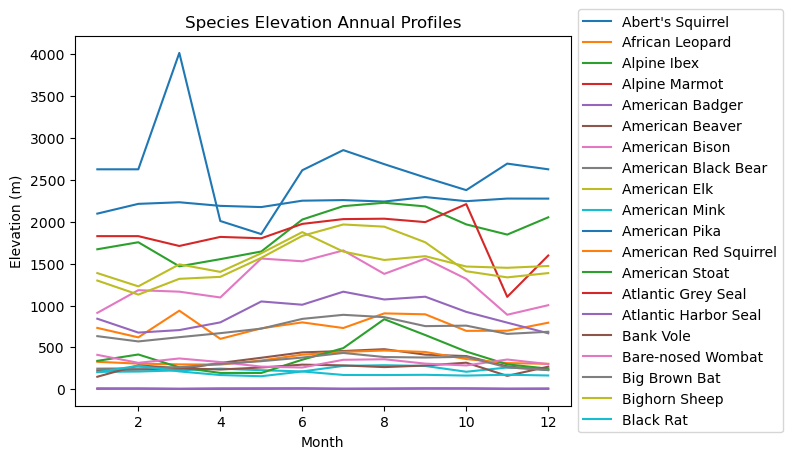

In [88]:
elevation_head.T.plot.line()

plt.title('Species Elevation Annual Profiles')
plt.xlabel('Month')
plt.ylabel('Elevation (m)')
plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

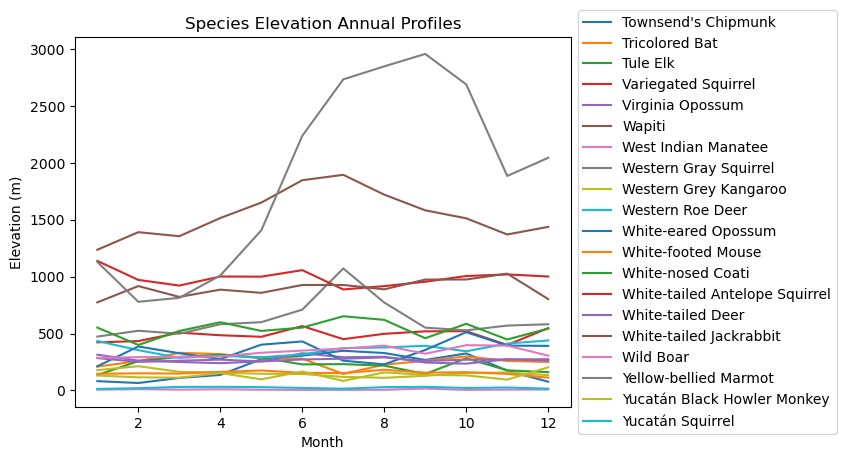

In [89]:
elevation_tail.T.plot.line()

plt.title('Species Elevation Annual Profiles')
plt.xlabel('Month')
plt.ylabel('Elevation (m)')
plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

### Temperature_2m Visualization

In [90]:
temperature_2m_df = wildlife_weather['temperature_2m'].to_frame()
temperature_2m_df = temperature_2m_df.reset_index(level=['observed_on'])
temperature_2m_df = temperature_2m_df.pivot(columns='observed_on', values='temperature_2m')
temperature_2m_df = temperature_2m_df.apply(lambda row: row.fillna(row.mean()), axis=1)

In [91]:
temperature_2m_df.head(90)

observed_on,1,2,3,4,5,6,7,8,9,10,11,12
common_name,,,,,,,,,,,,
Abert's Squirrel,-1.550000,3.434783,5.468750,12.058621,15.962222,19.954545,22.519048,22.092308,19.005882,15.286765,6.960606,1.929730
African Leopard,24.022727,24.966667,22.151429,21.590909,20.102326,18.987097,20.209375,20.240741,19.828889,24.837838,24.506000,25.382353
Alpine Ibex,-3.733333,0.878788,3.966667,5.759259,9.603077,13.112414,14.646610,13.553390,10.048148,7.954321,2.697727,-3.294444
Alpine Marmot,9.407895,9.407895,5.175000,5.228070,10.343779,13.733226,15.829881,15.067451,12.343206,9.008333,8.250000,-0.900000
American Badger,6.010526,11.378947,13.004545,13.853750,17.249635,21.963871,23.833607,25.096330,20.179688,15.598361,10.195652,8.145455
...,...,...,...,...,...,...,...,...,...,...,...,...
Eurasian Red Squirrel,-1.444940,1.437566,3.651051,9.633237,13.854920,20.277544,21.665101,21.103198,16.224661,11.218237,4.208230,0.158674
Eurasian Stoat,5.148276,5.115686,8.419231,9.747059,12.046552,16.834146,16.918841,16.431944,14.934884,11.018919,2.595000,6.096875
European Badger,4.096000,6.137168,7.675954,9.658086,13.504425,18.740756,20.703646,21.028723,16.165730,12.898295,9.300962,6.233028


Temperatures must be visualized seperately based on hemisphere of location due to seasonal differences

#### Southern Hemisphere

In [92]:
elephant_temp = temperature_2m_df.loc['Savannah Elephant']
koala_temp = temperature_2m_df.loc['Koala']
bra_guinea_temp = temperature_2m_df.loc['Brazilian Guinea Pig']
hippo_temp = temperature_2m_df.loc['Common Hippopotamus']

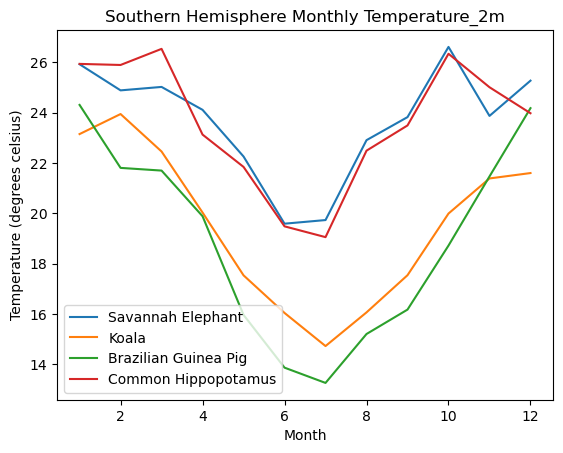

In [93]:
elephant_temp.plot.line()
koala_temp.plot.line()
bra_guinea_temp.plot.line()
hippo_temp.plot.line()

plt.title('Southern Hemisphere Monthly Temperature_2m')
plt.ylabel('Temperature (degrees celsius)')
plt.xlabel('Month')
plt.legend()
plt.show()

#### Nornern Hemisphere

In [94]:
east_squirrel_temp = temperature_2m_df.loc['Eastern Grey Squirrel']
bison_temp = temperature_2m_df.loc['American Bison']
mole_temp = temperature_2m_df.loc['European Mole']
moose_temp = temperature_2m_df.loc['Moose']

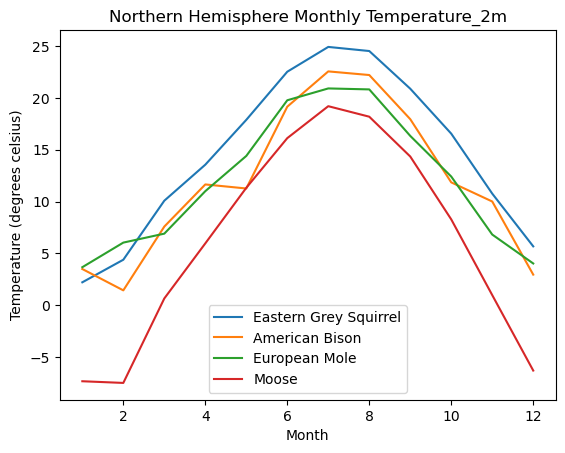

In [95]:
east_squirrel_temp.plot.line()
bison_temp.plot.line()
mole_temp.plot.line()
moose_temp.plot.line()

plt.title('Northern Hemisphere Monthly Temperature_2m')
plt.ylabel('Temperature (degrees celsius)')
plt.xlabel('Month')
plt.legend()
plt.show()

#### Wildlife Relative Surface Pressure

In [96]:
surface_pressure_df = wildlife_weather['surface_pressure'].to_frame()
surface_pressure_df = surface_pressure_df.reset_index(level=['observed_on'])
surface_pressure_df = surface_pressure_df.pivot(columns='observed_on', values='surface_pressure')
surface_pressure_df = surface_pressure_df.apply(lambda row: row.fillna(row.mean()), axis=1)

In [97]:
surface_pressure_head = surface_pressure_df.head(20).copy()
surface_pressure_tail = surface_pressure_df.tail(20).copy()

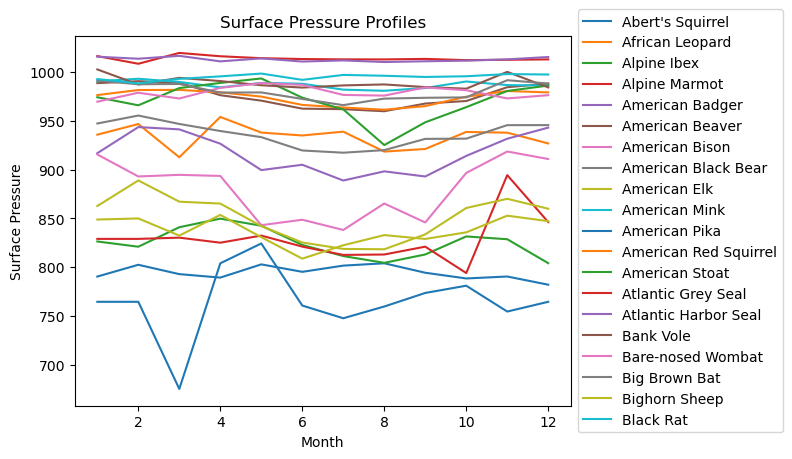

In [98]:
surface_pressure_head.T.plot.line()

plt.title('Surface Pressure Profiles')
plt.ylabel('Surface Pressure')
plt.xlabel('Month')
plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

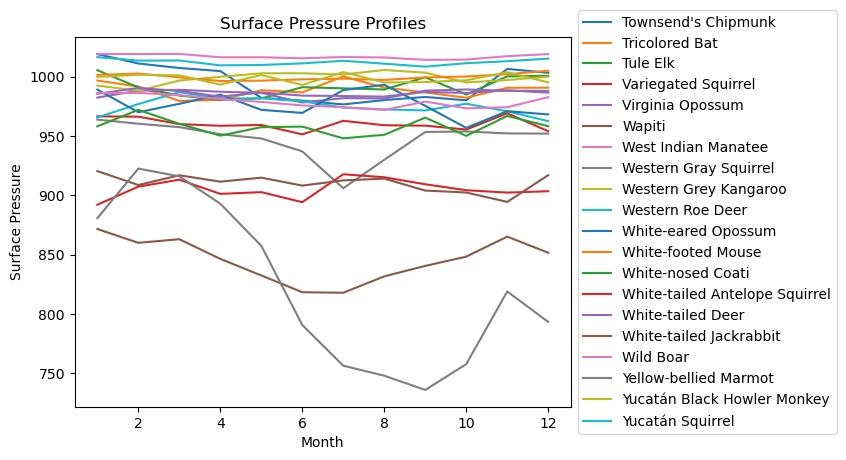

In [99]:
surface_pressure_tail.T.plot.line()

plt.title('Surface Pressure Profiles')
plt.ylabel('Surface Pressure')
plt.xlabel('Month')
plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

The temporal analysis is completed. Remove the following columns: observed_on, sunrise, sunset, timezone

In [100]:
df = df.drop(columns=['time_zone', 'observed_on', 'sunrise', 'sunset'])

Describe the final dataset

In [101]:
df.describe()

,elevation,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,surface_pressure,precipitation,rain,snowfall,cloudcover,...,et0_fao_evapotranspiration_daily,land,location_cluster,hemisphere,month,hour,light,szn_Spring,szn_Summer,szn_Autumn
count,901511.000000,901511.000000,901511.000000,901511.000000,901511.000000,901511.000000,901511.000000,901511.000000,901511.000000,901511.000000,...,901511.000000,901511.000000,901511.000000,901511.000000,901511.000000,901511.000000,901511.000000,901511.000000,901511.000000,901511.000000
mean,401.517065,16.326031,62.838001,8.134936,15.091515,971.191913,0.079415,0.076658,0.002025,39.686047,...,3.408563,0.968472,171.164000,0.933513,6.584051,12.827942,0.840500,0.316937,0.292603,0.237193
std,606.360062,9.086838,21.005773,8.993872,11.117487,62.868211,0.400974,0.397917,0.032485,35.739605,...,1.781122,0.174740,116.546079,0.249132,3.015149,4.838080,0.366142,0.465283,0.454958,0.425362
min,-270.000000,-39.900000,2.000000,-43.300000,-44.500000,568.700000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,10.600000,48.000000,2.300000,7.800000,968.900000,0.000000,0.000000,0.000000,5.000000,...,2.030000,1.000000,65.000000,1.000000,4.000000,9.000000,1.000000,0.000000,0.000000,0.000000
50%,180.000000,17.100000,64.000000,8.900000,15.700000,994.300000,0.000000,0.000000,0.000000,30.000000,...,3.330000,1.000000,159.000000,1.000000,6.000000,13.000000,1.000000,0.000000,0.000000,0.000000
75%,387.000000,23.000000,79.000000,14.600000,23.400000,1008.400000,0.000000,0.000000,0.000000,71.000000,...,4.640000,1.000000,256.000000,1.000000,9.000000,16.000000,1.000000,1.000000,1.000000,0.000000
max,5695.000000,49.800000,100.000000,28.600000,47.700000,1050.700000,26.000000,26.000000,3.710000,100.000000,...,15.630000,1.000000,399.000000,1.000000,12.000000,23.000000,1.000000,1.000000,1.000000,1.000000


In [102]:
df.to_csv('eda_complete.csv')

### PCA

Copy the dataframe, and remove all unneccessary columns including labels (species name and common name) in order to perform PCA.

In [103]:
df_pca = df.copy()
df_pca.head()

,image_url,scientific_name,common_name,elevation,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,surface_pressure,precipitation,...,et0_fao_evapotranspiration_daily,land,location_cluster,hemisphere,month,hour,light,szn_Spring,szn_Summer,szn_Autumn
id,,,,,,,,,,,,,,,,,,,,,
128984633,https://static.inaturalist.org/photos/21914219...,Phascolarctos cinereus,Koala,1000.0,7.6,99.0,7.5,5.1,902.3,0.0,...,1.91,1,41,0,8,0,0,0,0,0
129048796,https://inaturalist-open-data.s3.amazonaws.com...,Wallabia bicolor,Swamp Wallaby,166.0,9.7,76.0,5.7,4.3,992.5,0.0,...,1.98,1,188,0,8,7,0,0,0,0
129054418,https://inaturalist-open-data.s3.amazonaws.com...,Erinaceus europaeus,Common Hedgehog,65.0,17.3,85.0,14.7,17.9,1003.4,0.0,...,4.47,1,125,1,8,0,0,0,1,0
129076855,https://inaturalist-open-data.s3.amazonaws.com...,Arctocephalus forsteri,New Zealand Fur Seal,0.0,13.3,72.0,8.4,6.9,1010.6,0.1,...,2.16,0,112,0,8,13,1,0,0,0
129090780,https://inaturalist-open-data.s3.amazonaws.com...,Phascolarctos cinereus,Koala,1005.0,7.5,99.0,7.4,5.1,902.3,0.0,...,1.90,1,41,0,8,0,0,0,0,0


In [104]:
df_pca = df_pca.drop(columns=['image_url', 'scientific_name', 'weathercode_hourly', 'weathercode_daily'])

Standardize numerical columns for PCA

In [105]:
features = ['month', 'hour', 'elevation', 
            'location_cluster', 'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
            'apparent_temperature', 'surface_pressure', 'precipitation', 'rain',
            'snowfall', 'cloudcover', 'cloudcover_low', 'cloudcover_mid',
            'cloudcover_high', 'shortwave_radiation', 'direct_radiation',
            'diffuse_radiation', 'windspeed_10m', 'windspeed_100m',
            'winddirection_10m', 'winddirection_100m', 'windgusts_10m',
            'et0_fao_evapotranspiration_hourly', 'vapor_pressure_deficit', 'soil_temperature_0_to_7cm',
            'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm',
            'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm',
            'soil_moisture_28_to_100cm', 'temperature_2m_max',
            'temperature_2m_min', 'apparent_temperature_max',
            'apparent_temperature_min', 'precipitation_sum', 'rain_sum',
            'snowfall_sum', 'precipitation_hours', 'windspeed_10m_max', 'windgusts_10m_max', 'winddirection_10m_dominant',
            'shortwave_radiation_sum', 'et0_fao_evapotranspiration_daily']

In [106]:
# Sklearn standardizer
scaler = StandardScaler()

# Standardize numerical values
df_pca[features] = scaler.fit_transform(df_pca[features])

# Remove and keep labels
labels = df_pca['common_name'].copy()
df_pca = df_pca.drop(columns=['common_name'])

In [107]:
df_pca.head()

,elevation,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,surface_pressure,precipitation,rain,snowfall,cloudcover,...,et0_fao_evapotranspiration_daily,land,location_cluster,hemisphere,month,hour,light,szn_Spring,szn_Summer,szn_Autumn
id,,,,,,,,,,,,,,,,,,,,,
128984633,0.987010,-0.960294,1.721528,-0.070597,-0.898721,-1.095815,-0.198055,-0.192649,-0.062342,1.379813,...,-0.841360,1,-1.116846,0,0.469612,-2.651455,0,0,0,0
129048796,-0.388411,-0.729190,0.626590,-0.270733,-0.970680,0.338933,-0.198055,-0.192649,-0.062342,-0.802641,...,-0.802059,1,0.144458,0,0.469612,-1.204599,0,0,0,0
129054418,-0.554979,0.107185,1.055044,0.729949,0.252619,0.512311,-0.198055,-0.192649,-0.062342,-0.550819,...,0.595938,1,-0.396101,1,0.469612,-2.651455,0,0,1,0
129076855,-0.662176,-0.333013,0.436166,0.029472,-0.736814,0.626837,0.051338,0.058660,-0.062342,0.680309,...,-0.700999,0,-0.507645,0,0.469612,0.035563,1,0,0,0
129090780,0.995256,-0.971299,1.721528,-0.081715,-0.898721,-1.095815,-0.198055,-0.192649,-0.062342,1.379813,...,-0.846974,1,-1.116846,0,0.469612,-2.651455,0,0,0,0


In [108]:
pca = PCA().fit(df_pca)

In [109]:
print(pca.explained_variance_ratio_)

[2.48815832e-01 1.29491756e-01 9.78718939e-02 6.95817271e-02
 5.41748680e-02 5.22052996e-02 4.39050080e-02 3.60864415e-02
 3.29798901e-02 2.83336964e-02 2.56481094e-02 2.24403493e-02
 2.13205826e-02 1.88443115e-02 1.53401688e-02 1.23044303e-02
 1.02249980e-02 9.53342645e-03 9.07734153e-03 8.75023953e-03
 8.29882484e-03 5.90124607e-03 5.63964449e-03 5.21364662e-03
 4.61240430e-03 3.21601808e-03 2.44065975e-03 2.21737193e-03
 2.07142894e-03 1.98442756e-03 1.63900030e-03 1.39447532e-03
 1.30547813e-03 1.27767127e-03 7.71260859e-04 7.50552203e-04
 6.95503959e-04 6.26809648e-04 5.80699619e-04 5.19300752e-04
 4.82202553e-04 4.07874783e-04 3.75166229e-04 2.56415581e-04
 1.63615874e-04 1.37368663e-04 6.93206984e-05 1.98670787e-05
 1.03230726e-06 3.41425300e-07 4.90702707e-32]


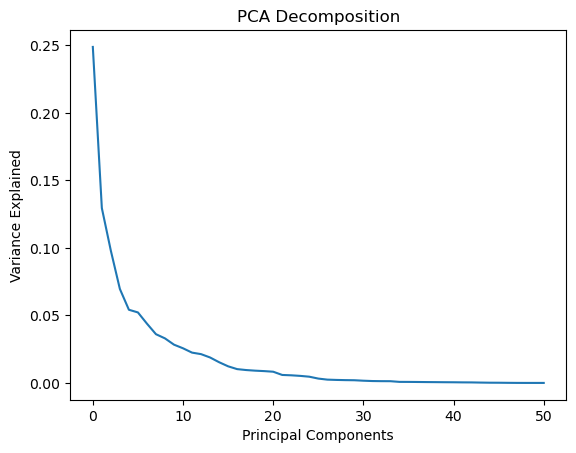

In [110]:
plt.plot(pca.explained_variance_ratio_)

plt.title('PCA Decomposition')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.show()

## Pipeline

The pipeline to clean, process and transform the data before model training

In [58]:
def aggregate_data() -> pd.DataFrame:
    wildlife_df = pd.read_csv(file_path + 'observations_final.csv', index_col=0)
    weather_df = pd.read_csv(file_path + 'weather_final.csv', index_col=0)
    
    weather_df = weather_df.drop(columns=['lat', 'long', 'time'])
    wildlife_df = wildlife_df.drop(columns=['observed_on', 'local_time_observed_at', 'positional_accuracy'])
    
    df = pd.merge(wildlife_df, weather_df, how='inner', left_index=True, right_index=True)
    return df
    

def pipeline(df, k_means):
    ## CLEAN-UP ##
    # Remove non-required columns
    df = df.drop(columns=['geoprivacy', 'taxon_geoprivacy', 'taxon_id', 'license', 'image_url', 'weathercode_hourly', 'weathercode_daily'])
    
    # Remove NaN values
    df = df.dropna(subset=['elevation', 'common_name'])
    
    # Remove observations with positional accuracy less than 10km
    df = df[df['public_positional_accuracy'] <= 35000]
    df = df.drop(columns=['public_positional_accuracy'])
    
    # Remove all species with less than 500 observations
    df = df[df.groupby('common_name').common_name.transform('count')>500].copy() 
    
    ## TRANSFORM ##
    # Transform date data
    # Generate UTC time stamp. Retrieve month [0, 12]
    df['observed_on'] = pd.to_datetime(df['observed_on'],
                                  format="%Y-%m-%d %H:%M:%S%z",
                                  utc=True)
    df['month'] = df['observed_on'].dt.month
    
    # Retrieve local time aware hour [0, 24]
    df['hour'] = df.apply(lambda x: x['observed_on'].astimezone(pytz.timezone(x['time_zone'])).hour,
                                axis=1)
    # Day/ Night OHE
    df = day_night_calculation(df)
    
    # Remove time zone, observed_on, sunrise, and sunset
    df = df.drop(columns=['time_zone', 'observed_on', 'sunrise', 'sunset'])
    
    # Transform geographical data
    # Northern and Southern Hemisphere OHE
    df['hemisphere'] = (df['latitude'] >= 0).astype(int)
    
    # Terrestrial or Aquatic Feature
    df = df.apply(lambda x: land_mask(x), axis=1)
    
    # Season calculation (taking into account hemisphere)
    df = df.apply(lambda x: season_calc(x), axis=1)
    df = ohe_season(df)
    
    # Clean elevation values based on terrestrial and aquatic label
    df = df.apply(lambda x: elevation_clean(x), axis=1)
    df['elevation'] = df['elevation'].fillna(df.groupby('common_name')['elevation'].transform('mean'))
    df = df.dropna(subset=['elevation'])
    
    # Allocate location clusters based on trained k_means model
    df['location_cluster'] = k_means.predict(df[['latitude', 'longitude']])   
    
    # Drop longitude and latitude columns
    df = df.drop(columns=['latitude', 'longitude'])
    
    ## Save Final Dataset ##
    df.to_csv('global_data_cache/final_data.csv')
    
    ## TRAIN & TEST DATA ##
    # Split data into train and test
    y = df['common_name'].copy()
    X = df.drop(columns=['common_name', 'scientific_name'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=35)
    
    return X_train, X_test, y_train, y_test

In [61]:
df_final = aggregate_data()

In [62]:
X_train, X_test, y_train, y_test = pipeline(df_final, k_means)

/home/travisdawson/anaconda3/envs/spatiotemp_class_env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


Preview training and test data

In [63]:
X_train.head(10)

,elevation,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,surface_pressure,precipitation,rain,snowfall,cloudcover,...,et0_fao_evapotranspiration_daily,month,hour,light,hemisphere,land,szn_Spring,szn_Summer,szn_Autumn,location_cluster
id,,,,,,,,,,,,,,,,,,,,,
92815850,251.000000,22.8,92.0,21.4,25.5,1001.5,0.0,0.0,0.0,100.0,...,1.21,8,14,1,1,1,0,1,0,52
141058419,20.000000,15.8,73.0,10.9,15.6,1020.5,0.0,0.0,0.0,89.0,...,0.95,10,8,1,1,1,0,0,1,243
68861041,223.000000,-1.2,44.0,-12.0,-6.3,1008.1,0.0,0.0,0.0,0.0,...,1.07,1,16,1,1,1,0,0,0,52
104838665,9.000000,25.7,86.0,23.2,31.0,1002.9,0.0,0.0,0.0,15.0,...,3.70,1,18,0,1,1,0,0,0,13
65326886,170.000000,2.4,75.0,-1.6,-1.5,1013.8,0.0,0.0,0.0,89.0,...,0.38,11,13,1,1,1,0,0,1,178
112851651,288.329917,24.0,84.0,21.1,24.1,1012.7,0.0,0.0,0.0,34.0,...,4.38,4,9,1,1,1,1,0,0,280
141894262,245.000000,-2.7,51.0,-11.6,-8.4,994.9,0.0,0.0,0.0,91.0,...,1.15,11,9,1,1,1,0,0,1,163
124785658,256.000000,0.6,66.0,-5.0,-2.8,980.8,0.0,0.0,0.0,82.0,...,1.73,4,0,0,1,1,1,0,0,289
98529310,6.000000,14.7,72.0,9.8,12.8,1019.2,0.0,0.0,0.0,53.0,...,3.07,10,14,1,0,1,1,0,0,79


In [64]:
y_train.head(10)

id
92815850                             Big Brown Bat
141058419                         Pallas' Squirrel
68861041                         White-tailed Deer
104838665    Central American white-faced capuchin
65326886                             European Mole
112851651                             Fox Squirrel
141894262                            Snowshoe Hare
124785658                    American Red Squirrel
98529310                     Eastern Grey Squirrel
63357136                     Nine-banded Armadillo
Name: common_name, dtype: object

## Simple Models

Due to the dataset size, the models cannot be trained on a Notebook. Instead the models are located in `src/models`. The results of the training are stored in `data_cache` and visualized below.

In [9]:
final_df = pd.read_csv('global_data_cache/final_data.csv')

In [10]:
final_df.head()

,id,scientific_name,common_name,elevation,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,surface_pressure,precipitation,...,et0_fao_evapotranspiration_daily,month,hour,light,hemisphere,land,szn_Spring,szn_Summer,szn_Autumn,location_cluster
0,128984633,Phascolarctos cinereus,Koala,1000.0,7.6,99.0,7.5,5.1,902.3,0.0,...,1.91,8,0,0,0,1,0,0,0,274
1,129048796,Wallabia bicolor,Swamp Wallaby,166.0,9.7,76.0,5.7,4.3,992.5,0.0,...,1.98,8,7,0,0,1,0,0,0,266
2,129054418,Erinaceus europaeus,Common Hedgehog,65.0,17.3,85.0,14.7,17.9,1003.4,0.0,...,4.47,8,0,0,1,1,0,1,0,181
3,129076855,Arctocephalus forsteri,New Zealand Fur Seal,0.0,13.3,72.0,8.4,6.9,1010.6,0.1,...,2.16,8,13,1,0,0,0,0,0,217
4,129090780,Phascolarctos cinereus,Koala,1005.0,7.5,99.0,7.4,5.1,902.3,0.0,...,1.90,8,0,0,0,1,0,0,0,274


In [11]:
y = final_df['common_name'].copy()
X = final_df.drop(columns=['common_name', 'scientific_name'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=35)

### Decision Tree

The decision tree models use cross-validation to determine the tree's optimal depth. 
If results are promising, further cross-validation can be utilized to determine the minimum sample splits to avoid over-sampling. 

Two score metrics are collected. 
1. Model accuracy: This metric provides an overall model accuracy but is biased due to the unbalanced dataset.
2. Balanced Model Accuracy: This metric takes into account unbalanced datasets, providing a mor realistic measure of accuracy. 

In [2]:
dt_accuracy = pd.read_csv('global_data_cache/decision_tree_accuracy.csv')
dt_balanced_accuracy = pd.read_csv('global_data_cache/decision_tree_balanced_accuracy.csv')

In [3]:
dt_accuracy.head()

,depth,mean_scores
0,5,0.154051
1,7,0.173723
2,9,0.196616
3,11,0.221537
4,13,0.242915


In [4]:
dt_balanced_accuracy.head()

,depth,mean_scores
0,5,0.043415
1,7,0.062728
2,9,0.092106
3,11,0.129780
4,13,0.158657


[]

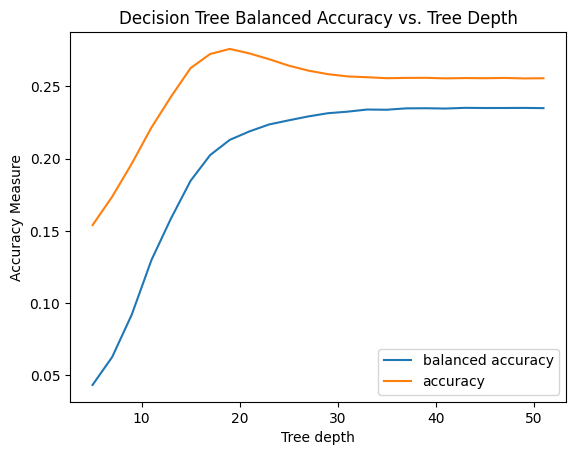

In [10]:
plt.plot(dt_balanced_accuracy['depth'], dt_balanced_accuracy['mean_scores'], label='balanced accuracy')
plt.plot(dt_accuracy['depth'], dt_accuracy['mean_scores'], label='accuracy')

plt.title('Decision Tree Balanced Accuracy vs. Tree Depth')
plt.xlabel('Tree depth')
plt.ylabel('Accuracy Measure')
plt.legend()
plt.plot()

### Random Forest

In [6]:
rf_accuracy = pd.read_csv('global_data_cache/random_forest_accuracy.csv')
rf_balanced_accuracy = pd.read_csv('global_data_cache/random_forest_balanced_accuracy.csv')

[]

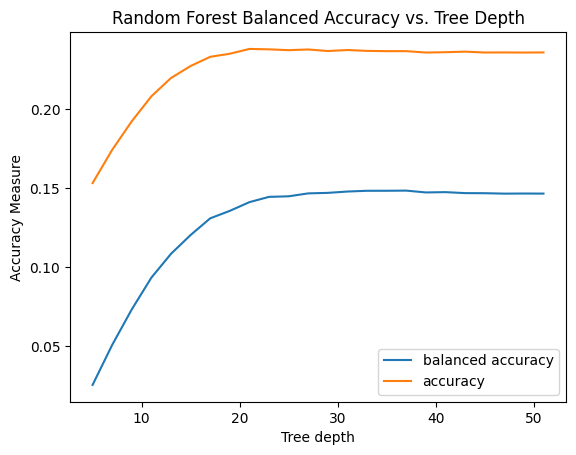

In [9]:
plt.plot(rf_balanced_accuracy['depth'], rf_balanced_accuracy['mean_scores'], label='balanced accuracy')
plt.plot(rf_accuracy['depth'], rf_accuracy['mean_scores'], label='accuracy')

plt.title('Random Forest Balanced Accuracy vs. Tree Depth')
plt.xlabel('Tree depth')
plt.ylabel('Accuracy Measure')
plt.legend()
plt.plot()